# IS319 - Deep Learning

## TP1 - Neural networks

The goal of this TP is to implement a simple feedforward neural network, but without the use of libraries like PyTorch or TensorFlow. We will only use NumPy.

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

### 1. Activation function and its derivative

**(Question)** Implement the following activation function and its respective gradient (vector of partial derivatives). These should be applied element-wise to the input vector `a`.

In [129]:
def sigmoid(a):
    '''Return the element-wise sigmoid of the input vector.'''
    return 1/(1+np.exp(-a))

def d_sigmoid(a):
    '''Return the partial derivatives of the sigmoid function
    with respect to the input vector.'''
    return sigmoid(a)*(1-sigmoid(a))

In [130]:
a = np.random.randn(100)
assert np.all(sigmoid(a) >= 0.)
assert np.all(sigmoid(a) <= 1.)
assert sigmoid(0.) == 0.5
assert np.all(d_sigmoid(a) >= 0.)
assert np.all(d_sigmoid(a) <= 0.25)

### 2. Loss function and its derivative

**(Question)** Implement the following loss function and its respective gradient (vector of partial derivatives).

`y` and `d` correspond to predictions and ground-truth labels respectively. They are assumed to be be matrices of size `n_classes * n_samples`.

In [131]:
def squared_error(y, d):
    '''Return a scalar corresponding to the sum of squared errors.'''
    # The sum instead of mean will be more convenient for this TP
    return np.sum((y - d)**2)
def d_squared_error(y, d):
    '''Return the vector of partial derivatives of the sum of
    squared errors with respect to the predictions.'''
    return 2*(y - d)

In [132]:
y = np.random.randn(3, 100)
d = np.random.randn(3, 100)
assert squared_error(y, d) >= 0.
assert d_squared_error(y, d).shape == y.shape

### 3. Neural network architecture

We will implement a simple fully-connected neural network with **one hidden layer** and **one output layer**.

This neural network is defined by a number of inputs, a number of hidden units, and a number of output units.

The activation function will be sigmoid and the loss function will be the sum of squared errors, both implemented above.

**(Question)** Complete the class below to initialize the weights and biases randomly.

In [133]:
class NeuralNetwork():
    def __init__(self, n_input, n_hidden, n_output):
        '''Initialize a neural network with `n_input` input neurons,
        `n_hidden` hidden neurons and `n_output` output neurons.'''
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.init_weights()
        
    def init_weights(self):
        '''Initialize random weights with attributes `W1`, `b1`, `W2` and `b2`.'''
        self.W1 = np.random.rand(self.n_hidden, self.n_input)
        self.b1 = np.random.rand(self.n_hidden, 1)
        self.W2 = np.random.rand(self.n_output, self.n_hidden)
        self.b2 = np.random.rand(self.n_output, 1)

In [134]:
nn = NeuralNetwork(64, 32, 3)
assert nn.W1.ndim == 2
assert nn.b1.ndim == 2
assert nn.W2.ndim == 2
assert nn.b2.ndim == 2

### 4. Forward pass

The forward pass is defined as:
$$\begin{align*}
\mathbf{h}_1 &= \sigma(\mathbf{a}_1) \quad\text{with}\quad \mathbf{a}_1 = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1 \\
\mathbf{y} &= \sigma(\mathbf{a}_2) \quad\text{with}\quad \mathbf{a}_2 = \mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2
\end{align*}$$

**(Question)** Implement the forward pass for input examples `X`. Save intermediate results `a1`, `h1` and `a2` into attributes (as they will be needed for the backpropagation algorithm).

In [135]:
class NeuralNetwork(NeuralNetwork): # (the method will be added to the `NeuralNetwork` class)
    def forward(self, X):
        self.a1 = self.W1@X + self.b1
        self.h1 = sigmoid(self.a1)
        self.a2 = self.W2@self.h1 + self.b2
        return sigmoid(self.a2)

In [136]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
y = nn.forward(X)
assert y.shape == (3, 100)

**(Question)** Implement the function below to obtain a classification decision from the network. To do that, apply the forward pass, then choose the class corresponding to the maximum output value.

*Hint:* use the `np.argmax` function.

In [137]:
class NeuralNetwork(NeuralNetwork): # (the method will be added to the `NeuralNetwork` class)
    def predict(self, X):
        return np.argmax(self.forward(X), axis = 0)

In [138]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
y = nn.predict(X)
assert y.shape == (100,)
assert np.any(y == 0) or np.any(y == 1) or np.any(y == 2)

### 5. Backward pass

**(Question)** Implement the backward pass for input examples `X`, ground-truth `d`, predictions `y`.

*Advice:* keep track of the shapes of each derivative using comments.

In [139]:
class NeuralNetwork(NeuralNetwork):
    def backward(self, X, y, d):
        '''Compute the partial derivatives of the loss function
        with respect to all weights of the neural network.
        Return these in variables `d_W1`, `d_b1`, `d_W2` and `d_b2`.'''
        # Backpropagation for the output layer
        # You should compute, d_ey, d_ya2, d_a2w2 and finally delta2
        # Then you can compute d_W2 and d_b2
        d_ey = d_squared_error(y, d)
        d_ya2 = d_sigmoid(self.a2)
        d_a2w2 = self.h1
        delta2 = d_ey*d_ya2
        d_W2 = delta2@d_a2w2.T
        d_b2 = np.sum(delta2, axis=1, keepdims=True)

        
        # Backpropagation for the hidden layer
        # You should comput d_h1a1 and finally delta1
        # Then you can compute d_W1 and d_b1
        d_h1a1 = d_sigmoid(self.a1)
        d_a1w1 = X
        delta1 = np.multiply(self.W2.T@delta2, d_h1a1)
        d_W1 = delta1@d_a1w1.T
        d_b1 = np.sum(delta1, axis=1, keepdims=True)

        
        return d_W1, d_b1, d_W2, d_b2

In [140]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
d = np.random.randint(0, 2, size=(3, 100))
y = nn.forward(X)
loss = squared_error(y, d)
d_W1, d_b1, d_W2, d_b2 = nn.backward(X, y, d)
assert d_W1.shape == nn.W1.shape
assert d_b1.shape == nn.b1.shape
assert d_W2.shape == nn.W2.shape
assert d_b2.shape == nn.b2.shape

### 6. Weights update with gradient descent

**(Question)** Complete the following code to implement one iteration of the training process:
- Apply the forward pass on training data and compute the loss
- Apply backpropagation to compute the gradient of the loss with respect to the network parameters
- Apply gradient descent to update the network parameters

In [141]:
class NeuralNetwork(NeuralNetwork):
    def train_iteration(self, X, d, lr=1e-2):
        # Apply forward pass and compute the loss
        y = self.forward(X)
        loss = squared_error(y, d)
        # Apply backpropagation to compute the gradients
        d_W1, d_b1, d_W2, d_b2 = self.backward(X, y, d)
           
        # Apply gradient descent to update the weights
        self.W1 = self.W1 - lr*d_W1
        self.b1 = self.b1 - lr*d_b1
        self.W2 = self.W2 - lr*d_W2
        self.b2 = self.b2 - lr*d_b2 
        loss = squared_error(y, d)
        return loss

In [142]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
d = np.random.randint(0, 2, size=(3, 100))
loss = nn.train_iteration(X, d, lr=100)
assert loss >= 0.

### 7. Mini-batch training loop

Now, we will implement the main training loop of our neural network.

We will use stochastic gradient descent with mini-batch: the weights will be updated by performing gradient descent on shuffled subsets of training data.

We will train the network for a number of epochs (an epoch is performed when the whole training set has been used with this mini-batch procedure).

**(Question)** Complete the code below to implement the training loop with minibatch stochastic gradient descent.

In [143]:
class NeuralNetwork(NeuralNetwork):
    def fit(self, X, d, batch_size, n_epochs=10, lr=1e-2):
        n_samples = X.shape[1]
        n_batches = (n_samples // batch_size) + 1
        epoch_loss = 0.
        for e in range(n_epochs):
            # Shuffle dataset
            permutation = np.random.permutation(n_samples)
            X, d = X[:, permutation], d[:, permutation]
            # Loop over each batch
            for b in range(0, n_samples, batch_size): # range(start, stop, step)
                # Grab the current batch in `X_batch` and `d_batch`
                X_batch = X[:, b:b+batch_size]
                d_batch = d[:, b:b+batch_size]
                # Apply training iteration and update epoch loss
                epoch_loss += self.train_iteration(X_batch, d_batch, lr)
        # Compute average epoch loss and print it
        print(f"Average epoch loss: {epoch_loss/(n_epochs*n_batches)}")
            

### 8. Train the network on the MNIST dataset

The MNIST dataset is composed of 70000 greyscale images of handwritten digits: 60000 images for training and 10000 for testing.

It is included in the `mnist.tgz` archive provided with this TP.

In [150]:
!tar xvzf ./mnist.tgz
images_train = np.load('./mnist-train-images.npy')
labels_train = np.load('./mnist-train-labels.npy')
images_test = np.load('./mnist-test-images.npy')
labels_test = np.load('./mnist-test-labels.npy')

mnist-test-images.npy
mnist-test-labels.npy
mnist-train-images.npy
mnist-train-labels.npy


**(Question)** Reshape the images into vectors and normalize the pixel values between 0 and 1. Convert the labels into one-hot vectors (*i.e.* vectors full of 0 and with only a 1 for the corresponding class). Store the results into `X_train`, `y_train`, `X_test` and `y_test` variables. Make sure to reshape to the following:
- Input data: `n_features x n_samples`
- Labels: `n_classes x n_samples`

In [161]:
n_samples_train = images_train.shape[0]
n_samples_test = images_test.shape[0]
X_train = np.moveaxis(images_train.reshape(n_samples_train, -1), 0, -1)
X_test = np.moveaxis(images_test.reshape(n_samples_test, -1), 0, -1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
n_classes = 10

#one hot encoding labels
y_train = np.zeros((n_classes, n_samples_train))
y_test = np.zeros((n_classes, n_samples_test))
for i in range(n_samples_train):
    y_train[labels_train[i], i] = 1
for i in range(n_samples_test):
    y_test[labels_test[i], i] = 1



In [162]:
assert np.all(X_train >= 0.) and np.all(X_train <= 1.)
assert np.all(X_test >= 0.) and np.all(X_test <= 1.)
assert np.all(np.unique(y_train) == np.array([0., 1.])) 
assert np.all(np.unique(y_test) == np.array([0., 1.]))
assert np.all(np.sum(y_train, axis=0) == 1.)
assert np.all(np.sum(y_test, axis=0) == 1.)

**(Question)** Initialize a neural network for MNIST with 32 hidden units and train it for 10 epochs with a batch size of 512.

In [163]:
nn = NeuralNetwork(28*28, 32, 10)
nn.fit(X_train, y_train, 512, 10, 10e-5)

Average epoch loss: 4576.269698322493


**(Question)** Compute the classification accuracy on the train and test sets. To do that, you can use the predict function and compare them with the original labels (*i.e.* without one-hot encoding).

In [167]:
pred_training = nn.predict(X_train)
pred_test = nn.predict(X_test)
accuracy_train = np.sum(pred_training == labels_train) / n_samples_train
accuracy_test = np.sum(pred_test == labels_test) / n_samples_test

In [168]:
assert(0. <= accuracy_train <= 1.)
assert(0. <= accuracy_test <= 1.)

**(Question)** Compute and plot the confusion matrix for the test set. Which are the most difficult classes? Show some examples of misclassified images.

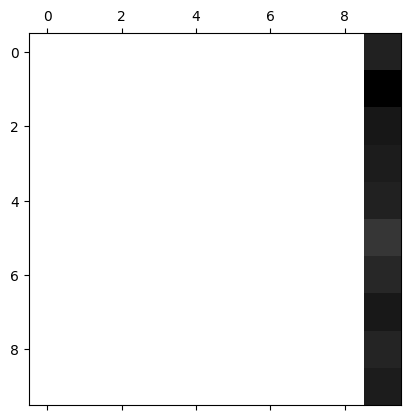

In [169]:
#Confusion matrix for test set
cm = confusion_matrix(labels_test, pred_test)
plt.matshow(cm, cmap='binary')


**(Question)** Play around with hyperparameters of the model. What happens when the batch size if very small? And very large?

In [170]:
# Different hyperparameters
nn = NeuralNetwork(28*28, 32, 10)
nn.fit(X_train, y_train, 512, 10, 10e-5)
pred_training = nn.predict(X_train)
pred_test = nn.predict(X_test)
accuracy_train = np.sum(pred_training == labels_train) / n_samples_train
accuracy_test = np.sum(pred_test == labels_test) / n_samples_test
print(f"Accuracy on training set: {accuracy_train}")
print(f"Accuracy on test set: {accuracy_test}")
# Different learning rate
nn1 = NeuralNetwork(28*28, 32, 10)
nn1.fit(X_train, y_train, 512, 10, 10e-4)
pred_training = nn1.predict(X_train)
pred_test = nn1.predict(X_test)
accuracy_train = np.sum(pred_training == labels_train) / n_samples_train
accuracy_test = np.sum(pred_test == labels_test) / n_samples_test
print(f"Accuracy on training set: {accuracy_train}")
print(f"Accuracy on test set: {accuracy_test}")
#Small batch size
nn2 = NeuralNetwork(28*28, 32, 10)
nn2.fit(X_train, y_train, 32, 10, 10e-5)
pred_training = nn2.predict(X_train)
pred_test = nn2.predict(X_test)
accuracy_train = np.sum(pred_training == labels_train) / n_samples_train
accuracy_test = np.sum(pred_test == labels_test) / n_samples_test
print(f"Accuracy on training set: {accuracy_train}")
print(f"Accuracy on test set: {accuracy_test}")



Average epoch loss: 4576.268598503578
Accuracy on training set: 0.09751666666666667
Accuracy on test set: 0.0974
Average epoch loss: 4576.270067033373
Accuracy on training set: 0.11236666666666667
Accuracy on test set: 0.1135
Average epoch loss: 287.8463986692248
Accuracy on training set: 0.09863333333333334
Accuracy on test set: 0.0958


For small batch size we observe very small average epoch loss compared to other models

### 9. (BONUS) Extension to softmax and categorical cross-entropy

**(Question)** Extend your neural network model to use a softmax activation function for the output layer, and a categorical cross-entropy loss.
You can also experiment with the reLU activation for the hidden layer.

*Hint:* recall the partial derivatives formulation from logistic regression, and optimize the backpropagation for the output layer accordingly.

In [127]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
def cross_entropy_loss(y, d):
    return -np.sum(d * np.log(y))
#derivative of cross entropy loss
def d_cross_entropy_loss(y, d):
    return y - d

def ReLU(x):
    return np.maximum(0, x)


class NeuralNetwork():
    def __init__(self, n_input, n_hidden, n_output):
        '''Initialize a neural network with `n_input` input neurons,
        `n_hidden` hidden neurons and `n_output` output neurons.'''
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.init_weights()
        
    def init_weights(self):
        '''Initialize random weights with attributes `W1`, `b1`, `W2` and `b2`.'''
        self.W1 = np.random.rand(self.n_hidden, self.n_input)
        self.b1 = np.random.rand(self.n_hidden, 1)
        self.W2 = np.random.rand(self.n_output, self.n_hidden)
        self.b2 = np.random.rand(self.n_output, 1)

    def forward(self, X):
        self.a1 = self.W1@X + self.b1
        self.h1 = ReLU(self.a1)
        self.a2 = self.W2@self.h1 + self.b2
        return softmax(self.a2)

    def backward(self, X, y, d):
        '''Compute the partial derivatives of the loss function
        with respect to all weights of the neural network.
        Return these in variables `d_W1`, `d_b1`, `d_W2` and `d_b2`.'''
        # Backpropagation for the output layer
        # You should compute, d_ey, d_ya2, d_a2w2 and finally delta2
        # Then you can compute d_W2 and d_b2
        d_ey = d_squared_error(y, d)
        d_ya2 = d_sigmoid(self.a2)
        d_a2w2 = self.h1
        delta2 = d_ey*d_ya2
        d_W2 = delta2@d_a2w2.T
        d_b2 = np.sum(delta2, axis=1, keepdims=True)

        
        # Backpropagation for the hidden layer
        # You should comput d_h1a1 and finally delta1
        # Then you can compute d_W1 and d_b1
        d_h1a1 = d_sigmoid(self.a1)
        d_a1w1 = X
        delta1 = np.multiply(self.W2.T@delta2, d_h1a1)
        d_W1 = delta1@d_a1w1.T
        d_b1 = np.sum(delta1, axis=1, keepdims=True)

    def train_iteration(self, X, d, lr=1e-2):
        # Apply forward pass and compute the loss
        y = self.forward(X)
        loss = squared_error(y, d)
        # Apply backpropagation to compute the gradients
        d_W1, d_b1, d_W2, d_b2 = self.backward(X, y, d)
           
        # Apply gradient descent to update the weights
        self.W1 = self.W1 - lr*d_W1
        self.b1 = self.b1 - lr*d_b1
        self.W2 = self.W2 - lr*d_W2
        self.b2 = self.b2 - lr*d_b2 
        loss = squared_error(y, d)
        return loss

    def fit(self, X, d, batch_size, n_epochs=10, lr=1e-2):
        n_samples = X.shape[1]
        n_batches = (n_samples // batch_size) + 1
        epoch_loss = 0.
        for e in range(n_epochs):
            # Shuffle dataset
            permutation = np.random.permutation(n_samples)
            X, d = X[:, permutation], d[:, permutation]
            # Loop over each batch
            for b in range(0, n_samples, batch_size): # range(start, stop, step)
                # Grab the current batch in `X_batch` and `d_batch`
                X_batch = X[:, b:b+batch_size]
                d_batch = d[:, b:b+batch_size]
                # Apply training iteration and update epoch loss
                epoch_loss += self.train_iteration(X_batch, d_batch, lr)
        # Compute average epoch loss and print it
        print(f"Average epoch loss: {epoch_loss/(n_epochs*n_batches)}")
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis = 0)
    
    

**(Question)** Extend your neural network model to handle more than one hidden layer.